This computation was originally done in Google Colab, and therefore our R was interpereted through python to allow us to mount a drive for storage of data and packages.

# Replicating Wu et al.

https://jasn.asnjournals.org/content/29/8/2069

The process for *Single-Cell Transcriptomics of a Human Kidney Allograft Biopsy Specimen Defines a Diverse Inflammatory Response* came from [this](https://jasn.asnjournals.org/content/jnephrol/suppl/2018/07/05/ASN.2018020125.DCSupplemental/ASN.2018020125SupplementaryData1.pdf) supplementary file provided on the website. Note that this analysis is based off of our best use of the methods provided

Download the file marked "Kidney.biospsy.dge" from this [link](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE109564)

In [ ]:
%reload_ext rpy2.ipython
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


Mounted at /content/drive


In [ ]:
%%R
#Create this directory if it does not yet exist
lib_loc <- "/content/drive/MyDrive/r-lib"
data_loc <- '/content/drive/Shareddrives/Research - Stephen/Organized Files/Datasets/Wu/Data/'

In [ ]:
%%R
library(dplyr, lib = lib_loc)
library(patchwork, lib = lib_loc)
library(Seurat, lib = lib_loc)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




The dowloaded file is read into a table and we create a Seurat object

In [ ]:
%%R
dataset.1 <- read.table(file = paste0(data_loc, "Kidney.biopsy.dge.txt"), row.names=1, header=T)
kid <- CreateSeuratObject(dataset.1, min.cells = 10)
kid[["percent.mt"]] <- PercentageFeatureSet(kid, pattern = "^MT-")

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



Next, this step performs normalization, finding variable features, scaling, PCA, and clustering all according to [this file](https://jasn.asnjournals.org/content/jnephrol/suppl/2018/07/05/ASN.2018020125.DCSupplemental/ASN.2018020125SupplementaryData1.pdf) on the 11th and 12th pages.

In [ ]:
%%R
kid <- NormalizeData(kid)
kid <- FindVariableFeatures(kid, selection.method = "mvp", mean.cutoff = c(0.0125, 6), dispersion.cutoff = c(1, Inf))
kid <- ScaleData(kid, vars.to.regress =  c("percent.mt", "nCount_RNA"))
kid <- RunPCA(kid)
kid <- FindNeighbors(kid, dims = 1:20)
kid <- FindClusters(kid, resolution = 0.6)
kid <- RunTSNE(kid, dims = 1:20)

R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4487
Number of edges: 187114

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.9000
Number of communities: 16
Elapsed time: 0 seconds


Next, we found the markers for our clusters and compared the top 5 markers of each cell with [this file](https://jasn.asnjournals.org/highwire/filestream/73175/field_highwire_adjunct_files/2/ASN.2018020125SupplementaryData3.xls) 

In [ ]:
markers <- FindAllMarkers(kid, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

For each of our cells, the top five markers in each one matched with the top five in the supplementary file, so we labeled them accordingly

In [ ]:
%%R
new.cluster.ids <- c("LOH (DL)", "EC", "PT", "Mono1", "LOH (AL)", "T cells", "Mono2", "Plasma1", "CD", "Pericyte", "Fibroblast", "B Cells", "Mast cells", "Myofibroblast", "Plasma2", "Cycling Cells")
names(new.cluster.ids) <- levels(kid)
kid <- RenameIdents(kid, new.cluster.ids)

And here is the UMAP of our replication

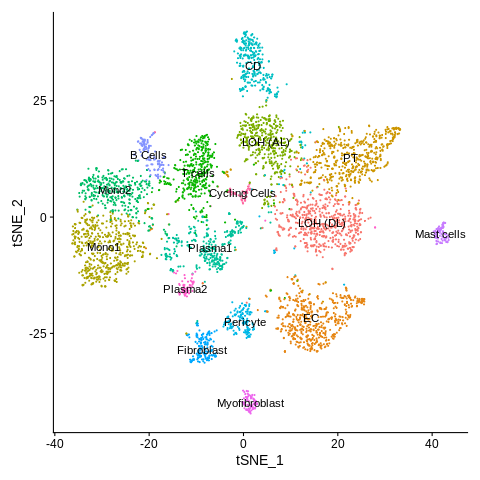

In [ ]:
%%R
DimPlot(kid, label = TRUE) + NoLegend()

In [ ]:
%%R
save(kid, file = 'wucolab')